This notebook is for exploring different inputs for supervised machine learning models. 

In [1]:
# Import necessary packages
import os
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import earthpy as et
import earthpy.spatial as es

In [ ]:
# For windows users
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

In [2]:
# Define area of interest and paths
aoi = 'koumassi_focus_ps'
koumassi_band_path = '..\\data\\'+aoi+"\\"
koumassi_raster_outputs_path = os.path.join(koumassi_band_path, "outputs\\raster_files\\")
koumassi_svm_outputs_path = os.path.join(koumassi_band_path, "outputs\\svm\\")

# Select all raw values needed for model development
# koumassi_raw_list = glob(koumassi_raster_outputs_path+"\\"+"*raw*")
# koumassi_raw_list.sort()

aoi2 = 'southeast_ps'
southeast_band_path = '..\\data\\'+aoi2+"\\"
southeast_raster_outputs_path = os.path.join(southeast_band_path, "outputs\\raster_files\\")
southeast_svm_outputs_path = os.path.join(southeast_band_path, "outputs\\svm\\")
combined_svm_outputs_path = '..\\data\\combined\\'

# Select all raw values needed for model development
# southeast_raw_list = glob(southeast_raster_outputs_path+"\\"+"*raw*")
# southeast_raw_list.sort()

# Select all raw value arrays needed for model development
koumassi_raw_list = glob(koumassi_raster_outputs_path+"\\"+"*raw*")
koumassi_raw_list.sort()
southeast_raw_list = glob(southeast_raster_outputs_path+"\\"+"*raw*")
southeast_raw_list.sort()

In [3]:
aoi_clf = 'southeast_ps'
band_path_clf = '..\\data\\'+aoi_clf+"\\"
svm_outputs_path_clf = os.path.join(band_path_clf, "outputs\\svm\\")
southeast_svm_clf = pickle.load(open(svm_outputs_path_clf+'pickle_svm_424', 'rb'))

In [4]:
# Get meta data for writing out SVM result
koumassi_all_bands_path = os.path.join(koumassi_raster_outputs_path + aoi+"_all_bands.tif")
with rio.open(koumassi_all_bands_path) as src:
    koumassi_all_bands_stack = src.read()
    stack_meta = src.meta
    koumassi_files_out_meta = src.meta.copy()
koumassi_files_out_meta['count']=1


# Get meta data for writing out SVM result
southeast_all_bands_path = os.path.join(southeast_raster_outputs_path + aoi2+"_all_bands.tif")
with rio.open(southeast_all_bands_path) as src:
    southeast_all_bands_stack = src.read()
    stack_meta = src.meta
    southeast_files_out_meta = src.meta.copy()
southeast_files_out_meta['count']=1

In [5]:
validation_data_path = os.path.join('..\\data\\combined\\validation\\')
koumassi_sample_pts = gpd.read_file(
    validation_data_path+"vector-data\\additional_val_points_koumassi.shp")
southeast_sample_pts = gpd.read_file(
    validation_data_path+"vector-data\\additional_val_points_southeast.shp")

In [6]:
# Sample index values at reference points for koumassi
# Create tuples of all x coordinates and y coordinates 
x_coords_koumassi = tuple(koumassi_sample_pts.geometry.x)
y_coords_koumassi = tuple(koumassi_sample_pts.geometry.y)

i = 0
index_list = []
filename=[]

for raw in koumassi_raw_list:
    sampled_values = []
    
    # Sample raster at each combo of x and y coordinates
    with rio.open(raw) as src:
        for val in src.sample(zip(x_coords_koumassi, y_coords_koumassi)):
            i = i+1
        # Note that each val is an individual numpy array
        # print(val.shape)
            sampled_values.append(val)
        arr = np.array([sampled_values]).squeeze()
        index_list.append([arr])
        filename.append(raw[51:71])
        
labels = filename
index_vals_koumassi = pd.DataFrame(np.concatenate(index_list))
index_vals_koumassi = index_vals_koumassi.transpose()
index_vals_koumassi.columns=labels

# Write out index values for reference points as CSV
filepath = validation_data_path+"index_vals_koumassi.csv"
index_vals_koumassi.to_csv(filepath) 

In [7]:
# Sample index values at reference points for southeast
# Create tuples of all x coordinates and y coordinates 
x_coords_southeast = tuple(southeast_sample_pts.geometry.x)
y_coords_southeast = tuple(southeast_sample_pts.geometry.y)

i = 0
index_list = []
filename=[]

for raw in southeast_raw_list:
    sampled_values = []
    
    # Sample raster at each combo of x and y coordinates
    with rio.open(raw) as src:
        for val in src.sample(zip(x_coords_southeast, y_coords_southeast)):
            i = i+1
        # Note that each val is an individual numpy array
        # print(val.shape)
            sampled_values.append(val)
        arr = np.array([sampled_values]).squeeze()
        index_list.append([arr])
        filename.append(raw[46:71])
        
labels = filename
index_vals_southeast = pd.DataFrame(np.concatenate(index_list))
index_vals_southeast = index_vals_southeast.transpose()
index_vals_southeast.columns=labels

# Write out index values for reference points as CSV
filepath = validation_data_path+"index_vals_southeast.csv"
index_vals_southeast.to_csv(filepath) 

In [8]:
# Combine validation data with index values for koumassi
valid_data_koumassi = pd.read_csv(validation_data_path+"additional_val_points_koumassi.csv")
train_data_koumassi = pd.concat([valid_data_koumassi,index_vals_koumassi], axis=1, sort=False)
train_data_koumassi =train_data_koumassi.iloc[:,[1,2,3,4,5,7,8,10,11]]
train_data_koumassi.head()

,ClassValue,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,2,0.1846,0.001091,0.111064,-0.011570,-0.000799,-0.111863,0.000000,-0.111064
1,2,0.1706,0.005009,0.094227,-0.029991,0.092105,-0.002122,0.043328,-0.050900
2,1,0.1630,0.000000,0.131636,0.006560,-0.106168,-0.237804,-0.013902,-0.145538
3,1,0.1616,0.002909,0.142139,-0.008547,-0.044550,-0.186688,-0.024164,-0.166302
4,1,0.1916,0.000000,0.182211,0.021898,-0.168335,-0.350546,-0.039676,-0.221887


In [9]:
# Combine validation data with index values for southeast
valid_data_southeast = pd.read_csv(validation_data_path+"additional_val_points_southeast.csv")
train_data_southeast = pd.concat([valid_data_southeast,index_vals_southeast], axis=1, sort=False)
# train_data_southeast = train_data_southeast[:,[1,2,3,4,5,6,7,8,9]]
train_data_southeast =train_data_southeast.iloc[:,[1,2,3,4,5,6,7,8,9]]
train_data_southeast.head()

,ClassValue,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,2,0.7526,0.032580,0.026123,0.134679,-0.394132,-0.420254,-0.157594,-0.183717
1,2,0.8285,0.006114,0.043177,0.149244,-0.365778,-0.408955,-0.215826,-0.259003
2,2,0.3688,0.013539,0.026273,-0.286490,0.103074,0.076801,0.495422,0.469150
3,2,0.4671,0.010830,0.007302,-0.212443,-0.026115,-0.033418,0.419335,0.412033
4,2,0.5042,0.019964,0.005632,-0.178983,-0.076766,-0.082397,0.373623,0.367991


In [10]:
# Create dataframe with  validation classes and index values
# Validation data CSV created using ArcGIS
# koumassi_ref_data = pd.read_csv(koumassi_svm_outputs_path+"reference_data_koumassi.csv")
# southeast_ref_data = pd.read_csv(southeast_svm_outputs_path+"reference_data_southeast.csv")



# concat_list = [koumassi_ref_data,southeast_ref_data]
train_data = train_data_koumassi.append(train_data_southeast)

train_data.shape

(3222, 9)

In [11]:
# Define training dataset
XX =train_data.iloc[:,[1,2,3,4,5,6,7,8]]
X = train_data.iloc[:,[1,2,3,4,5,6,7,8]].values
y = train_data.iloc[:,0].values

# pd.DataFrame(X).to_csv(svm_outputs_path+"X_koumassi.csv")
# pd.DataFrame(y).to_csv(svm_outputs_path+"y_koumassi.csv")
XX.head()


,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,0.1846,0.001091,0.111064,-0.011570,-0.000799,-0.111863,0.000000,-0.111064
1,0.1706,0.005009,0.094227,-0.029991,0.092105,-0.002122,0.043328,-0.050900
2,0.1630,0.000000,0.131636,0.006560,-0.106168,-0.237804,-0.013902,-0.145538
3,0.1616,0.002909,0.142139,-0.008547,-0.044550,-0.186688,-0.024164,-0.166302
4,0.1916,0.000000,0.182211,0.021898,-0.168335,-0.350546,-0.039676,-0.221887


In [12]:
# Split reference dataset, hold back 40% for external validation, 60% for internal train/test
Xint, Xext, yint, yext = train_test_split(X, y, test_size=0.4)

In [13]:
pd.DataFrame(Xext).to_csv(combined_svm_outputs_path+"Xext_add_points_v3.csv")
pd.DataFrame(yext).to_csv(combined_svm_outputs_path+"yext_add_points_v3.csv")
pd.DataFrame(Xint).to_csv(combined_svm_outputs_path+"Xint_add_points_v3.csv")
pd.DataFrame(yint).to_csv(combined_svm_outputs_path+"yint_add_points_v3.csv")

In [55]:
# Split training dataset, test size is 40%, training size 60%
Xtrain, Xtest, ytrain, ytest = train_test_split(Xint, yint, test_size=0.4)

In [56]:
# Define SVC classifier with linear kernel. Run cells 8 and 9 until happy with accuracy score.
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
accuracy_score(ytest, ypred)

0.9315245478036176

In [38]:
# Save out SVM classifier with highest accuracy score. 

# Final SVM model saved with accuracy score of 0.9483204134366925
# new3 for koumassic plus new for southeast
# Includes dark.tif 	mbi.tif 	msi.tif 	ndvi.tif 	ndwi_coastal.tif 	ndwi_coastal_msi.tif 	ndwi_yellow.tif 	ndwi_yellow_msi.tif
pickle.dump(clf, open(combined_svm_outputs_path+'pickle_combined_svm_additional_points_v3', 'wb'))

# Final SVM model saved with accuracy score of 0.963265306122449
# new3 for koumassic plus new for southeast
# Includes dark.tif 	mbi.tif 	msi.tif 	ndvi.tif 	ndwi_coastal.tif 	ndwi_coastal_msi.tif 	ndwi_yellow.tif 	ndwi_yellow_msi.tif
# pickle.dump(clf, open(combined_svm_outputs_path+'pickle_combined_svm_additional_points_v2', 'wb'))

# Final SVM model saved with accuracy score of 0.9643916913946587
# new3 for koumassic plus new for southeast
# Includes dark.tif 	mbi.tif 	msi.tif 	ndvi.tif 	ndwi_coastal.tif 	ndwi_coastal_msi.tif 	ndwi_yellow.tif 	ndwi_yellow_msi.tif
# pickle.dump(clf, open(combined_svm_outputs_path+'pickle_combined_svm_additional_points', 'wb'))


In [ ]:
# Define SVM classifier with rbf kernel
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(Xtrain, ytrain)
ypred_rbf = clf_rbf.predict(Xtest)
accuracy_score(ytest, ypred_rbf)

In [ ]:
 # Save out SVM classifier with rbf kernel, accuracy score of 0.9406528189910979
pickle.dump(clf_rbf, open(combined_svm_outputs_path+'pickle_combined_svm_rbf_additional_points_v2', 'wb'))

In [ ]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))
plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Vegetation', 'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow','True \n Flood','True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
#Print confusion matrix for rbf kernel SVM
print(confusion_matrix(ytest, ypred_rbf))
plt.imshow(confusion_matrix(ytest, ypred_rbf),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Vegetation', 'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow','True \n Flood','True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

# Validation with 40% of data held back from SVM model development

In [ ]:
# # Create tuples of all x coordinates and y coordinates 
# x_valid_coords = tuple(sample_pts_40perc.geometry.x)
# y_valid_coords = tuple(sample_pts_40perc.geometry.y)

# i = 0
# index_valid_list = []
# filename=[]

# for raw in raw_list:
#     sampled_values = []
    
#     # Sample raster at each combo of x and y coordinates
#     with rio.open(raw) as src:
#         for val in src.sample(zip(x_valid_coords, y_valid_coords)):
#             i = i+1
#         # Note that each val is an individual numpy array
#         # print(val.shape)
#             sampled_values.append(val)
#         arr = np.array([sampled_values]).squeeze()
#         index_valid_list.append([arr])
#         filename.append(raw[50:78])
        

# labels = filename
# index_valid_df = pd.DataFrame(np.concatenate(index_valid_list))
# index_valid_df = index_valid_df.transpose()
# index_valid_df.columns=labels
# filepath = validation_data_path+"raw_index_values_40perc.csv"
# index_valid_df.to_csv(filepath) 

In [ ]:
# # Create dataframe with  validation classes and index values
# # Validation data CSV created using ArcGIS
# valid_40_data = pd.read_csv(validation_data_path+"koumassi_validation_data_40_percent.csv")
# external_valid_df = pd.concat([valid_40_data,index_valid_df], axis=1, sort=False)

In [ ]:
# # Define external validation dataset
# XXvalid = external_valid_df.iloc[:,[2,3,4,5,6,8,9]]
# Xvalid = external_valid_df.iloc[:,[2,3,4,5,6,8,9]].values
# yvalid = external_valid_df.iloc[:,1].values
# XXvalid.head()

In [57]:
# Load saved SVM classifer
# loaded_clf = pickle.load(open(svm_outputs_path+'pickle_svm_final_with_ndvi_ndwi_yellow', 'rb'))
loaded_clf = pickle.load(open(combined_svm_outputs_path+'pickle_combined_svm_additional_points_v3', 'rb'))

# Apply linear kernel SVM classifier to external dataset
ypred_valid = clf.predict(Xext)
accuracy_score(yext, ypred_valid)

0.9340574088440652

[[327   9   1   3]
 [ 24 300   2  13]
 [  0   2 250   1]
 [  0  30   0 327]]


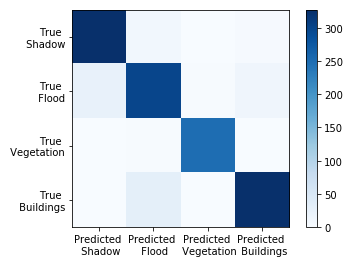

In [58]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(yext, ypred_valid))

plt.imshow(confusion_matrix(yext, ypred_valid),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Vegetation', 'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow','True \n Flood','True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)


In [ ]:
# Write out confusion matrix array
confusion_svm_external = confusion_matrix(yext, ypred_valid)
pd.DataFrame(confusion_svm_external).to_csv(combined_svm_outputs_path+'confusion_svm_external_additional_points_v2.csv')

In [ ]:
# Load saved SVM classifer with rbf kernel
loaded_clf_rbf = pickle.load(open(combined_svm_outputs_path+'pickle_combined_svm_rbf_424', 'rb'))
# Apply rbf kernel SVM classifier to external dataset
ypred_rbf_valid = loaded_clf_rbf.predict(Xext)
accuracy_score(yext, ypred_rbf_valid)

In [ ]:
#Print confusion matrix for rbf kernel SVM
print(confusion_matrix(yext, ypred_rbf_valid))

plt.imshow(confusion_matrix(yext, ypred_rbf_valid),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Vegetation', 'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow','True \n Flood','True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)


# Developing map based on trained SVM model with linear kernel

In [59]:
# Select all raw value arrays needed for model development
koumassi_raw_list = glob(koumassi_raster_outputs_path+"\\"+"*raw*")
koumassi_raw_list.sort()
southeast_raw_list = glob(southeast_raster_outputs_path+"\\"+"*raw*")
southeast_raw_list.sort()

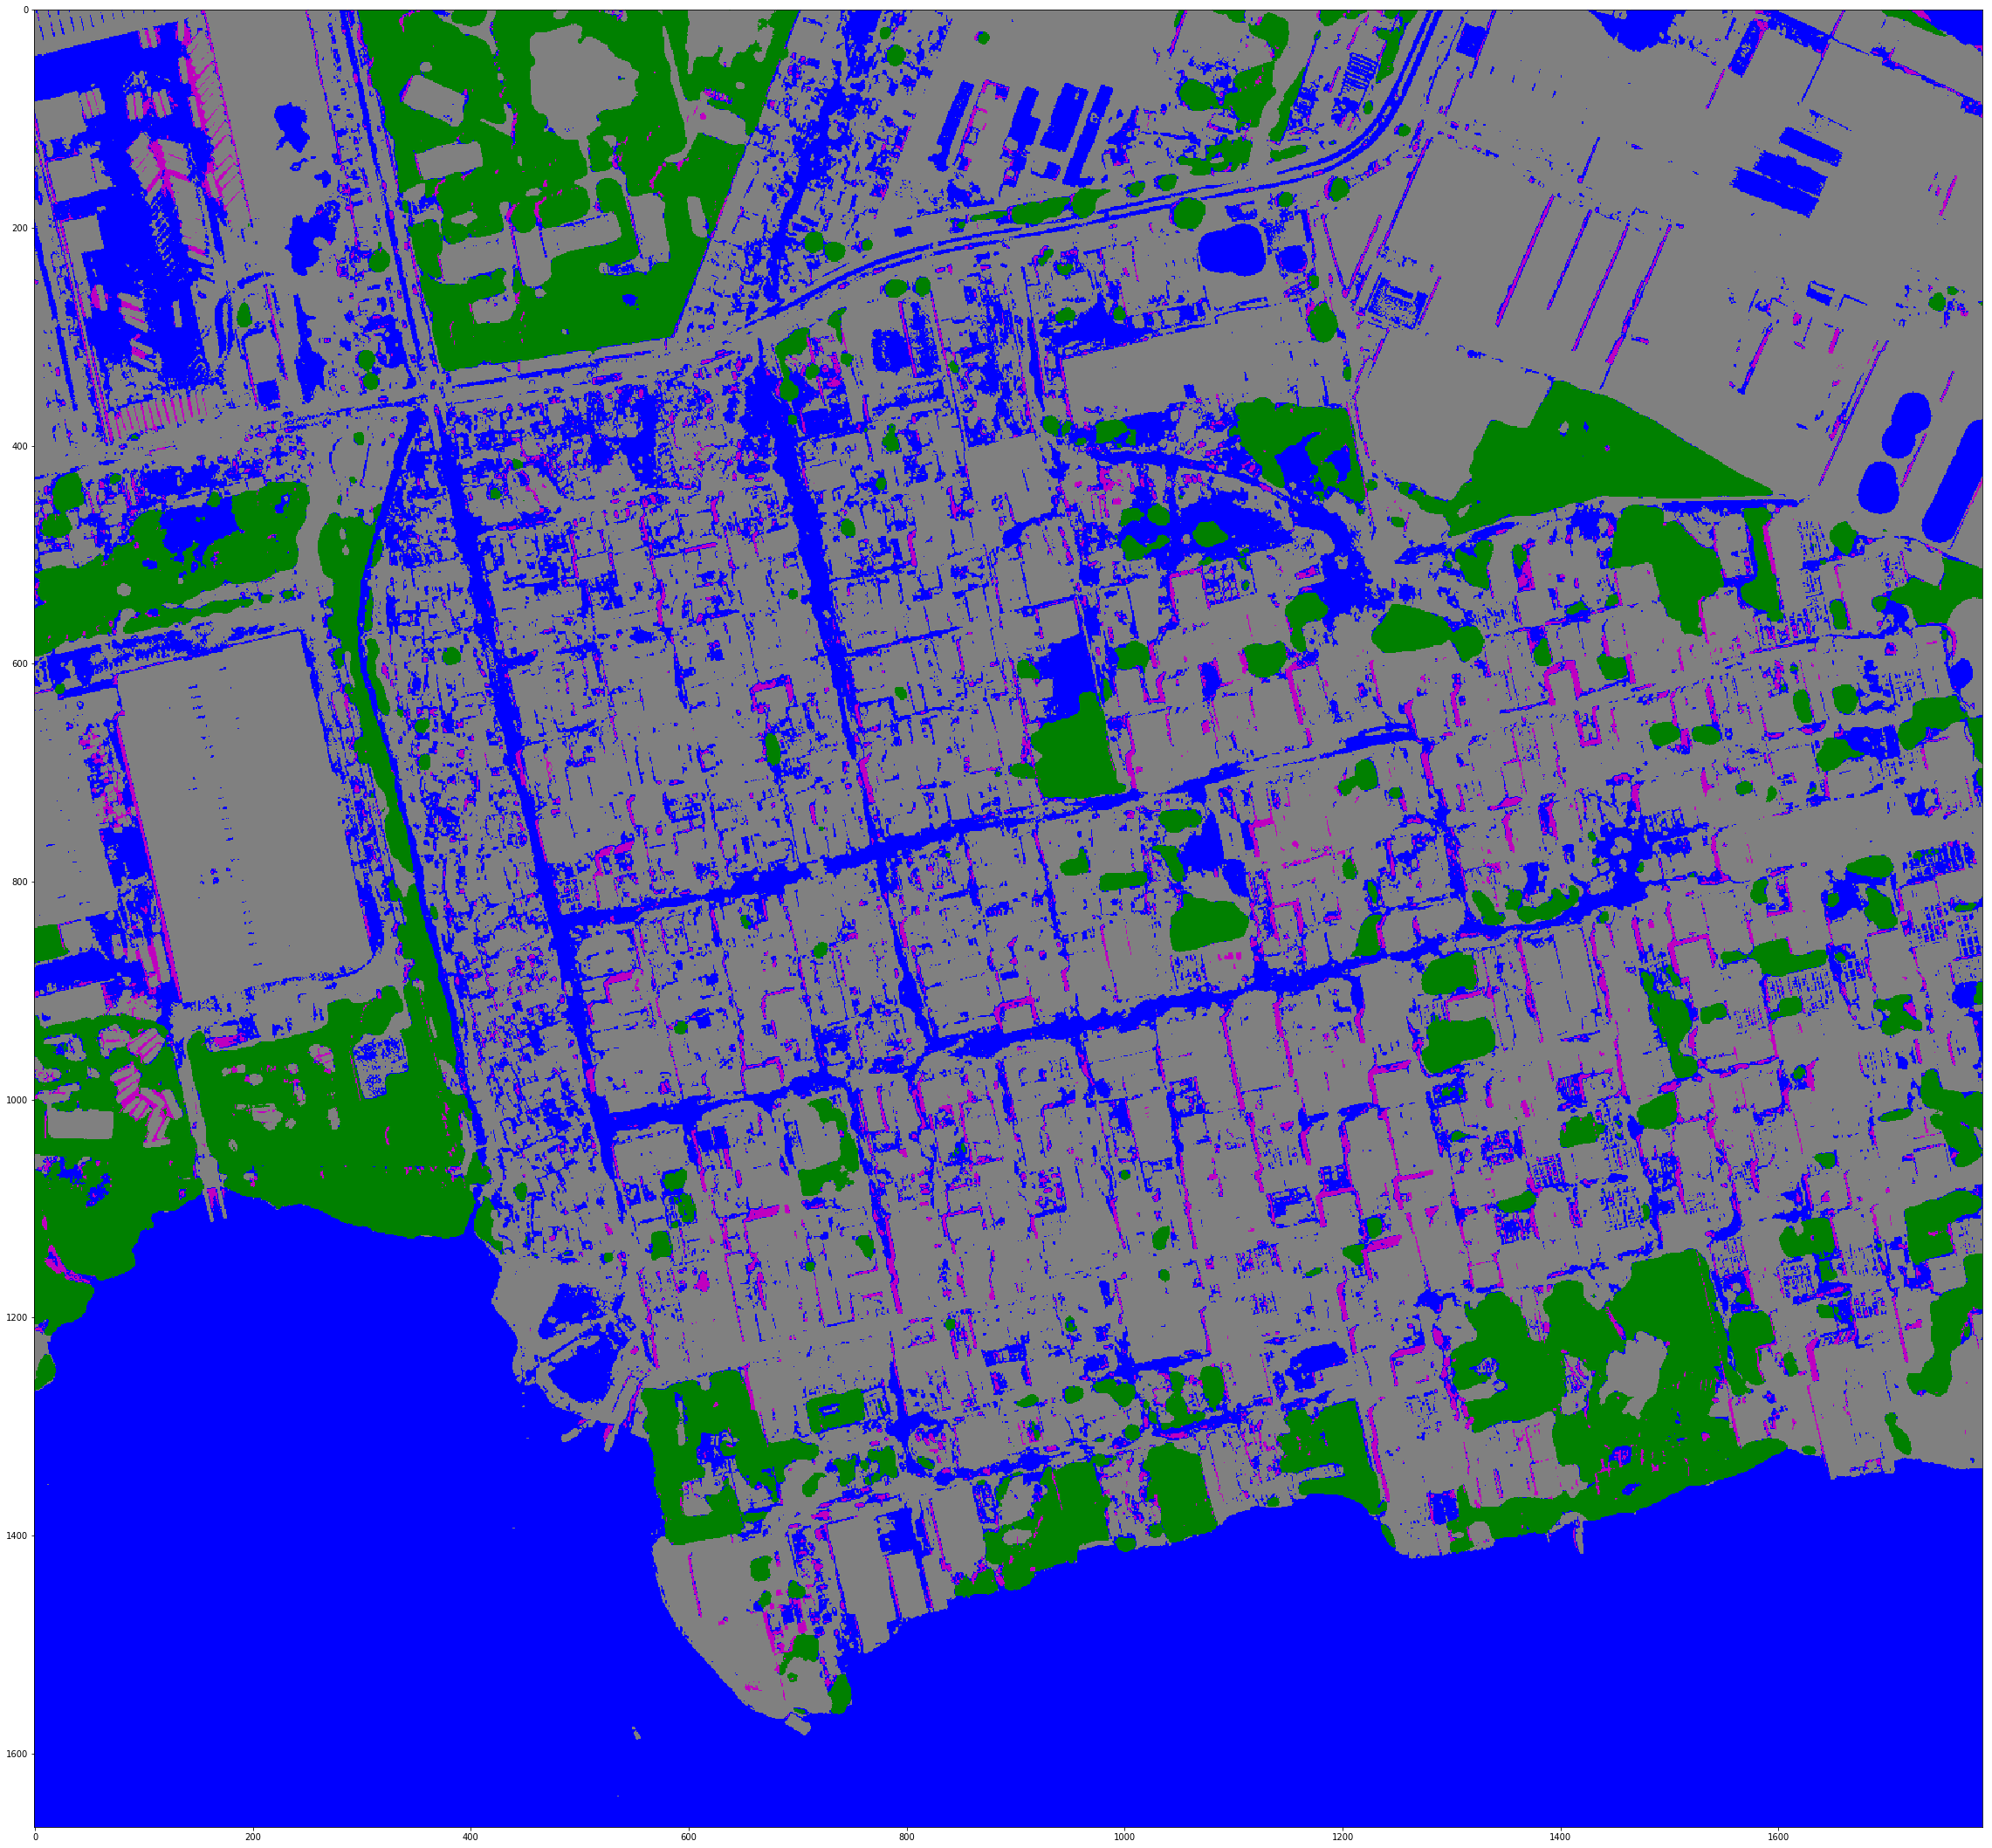

In [60]:
# Create stack of inputs for entire image and apply saved linear SVM classifer
b = [0,1,2,3,5,6,8,9]
koumassi_raw_list = [koumassi_raw_list[i] for i in b]
# c = [a[i] for i in b]
koumassi_index_stack, k_meta = es.stack(koumassi_raw_list)
koumassi_index_im = np.rollaxis(koumassi_index_stack, 0, 3)
X_koumassi_index = koumassi_index_im.reshape(-1,8) #Update based on number of model params
predictedClass = loaded_clf.predict(X_koumassi_index)

# Plot SVM map
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(koumassi_index_im.shape[:2])
cmap = ListedColormap(['m','blue','green','grey'])
ax.imshow(pred_data,cmap=cmap)
plt.show()

In [61]:
# Write out SVM map
with rio.open(combined_svm_outputs_path+'koumassi_SVM_map_combined_additional_points_v3.tif', 'w', **koumassi_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'),1)

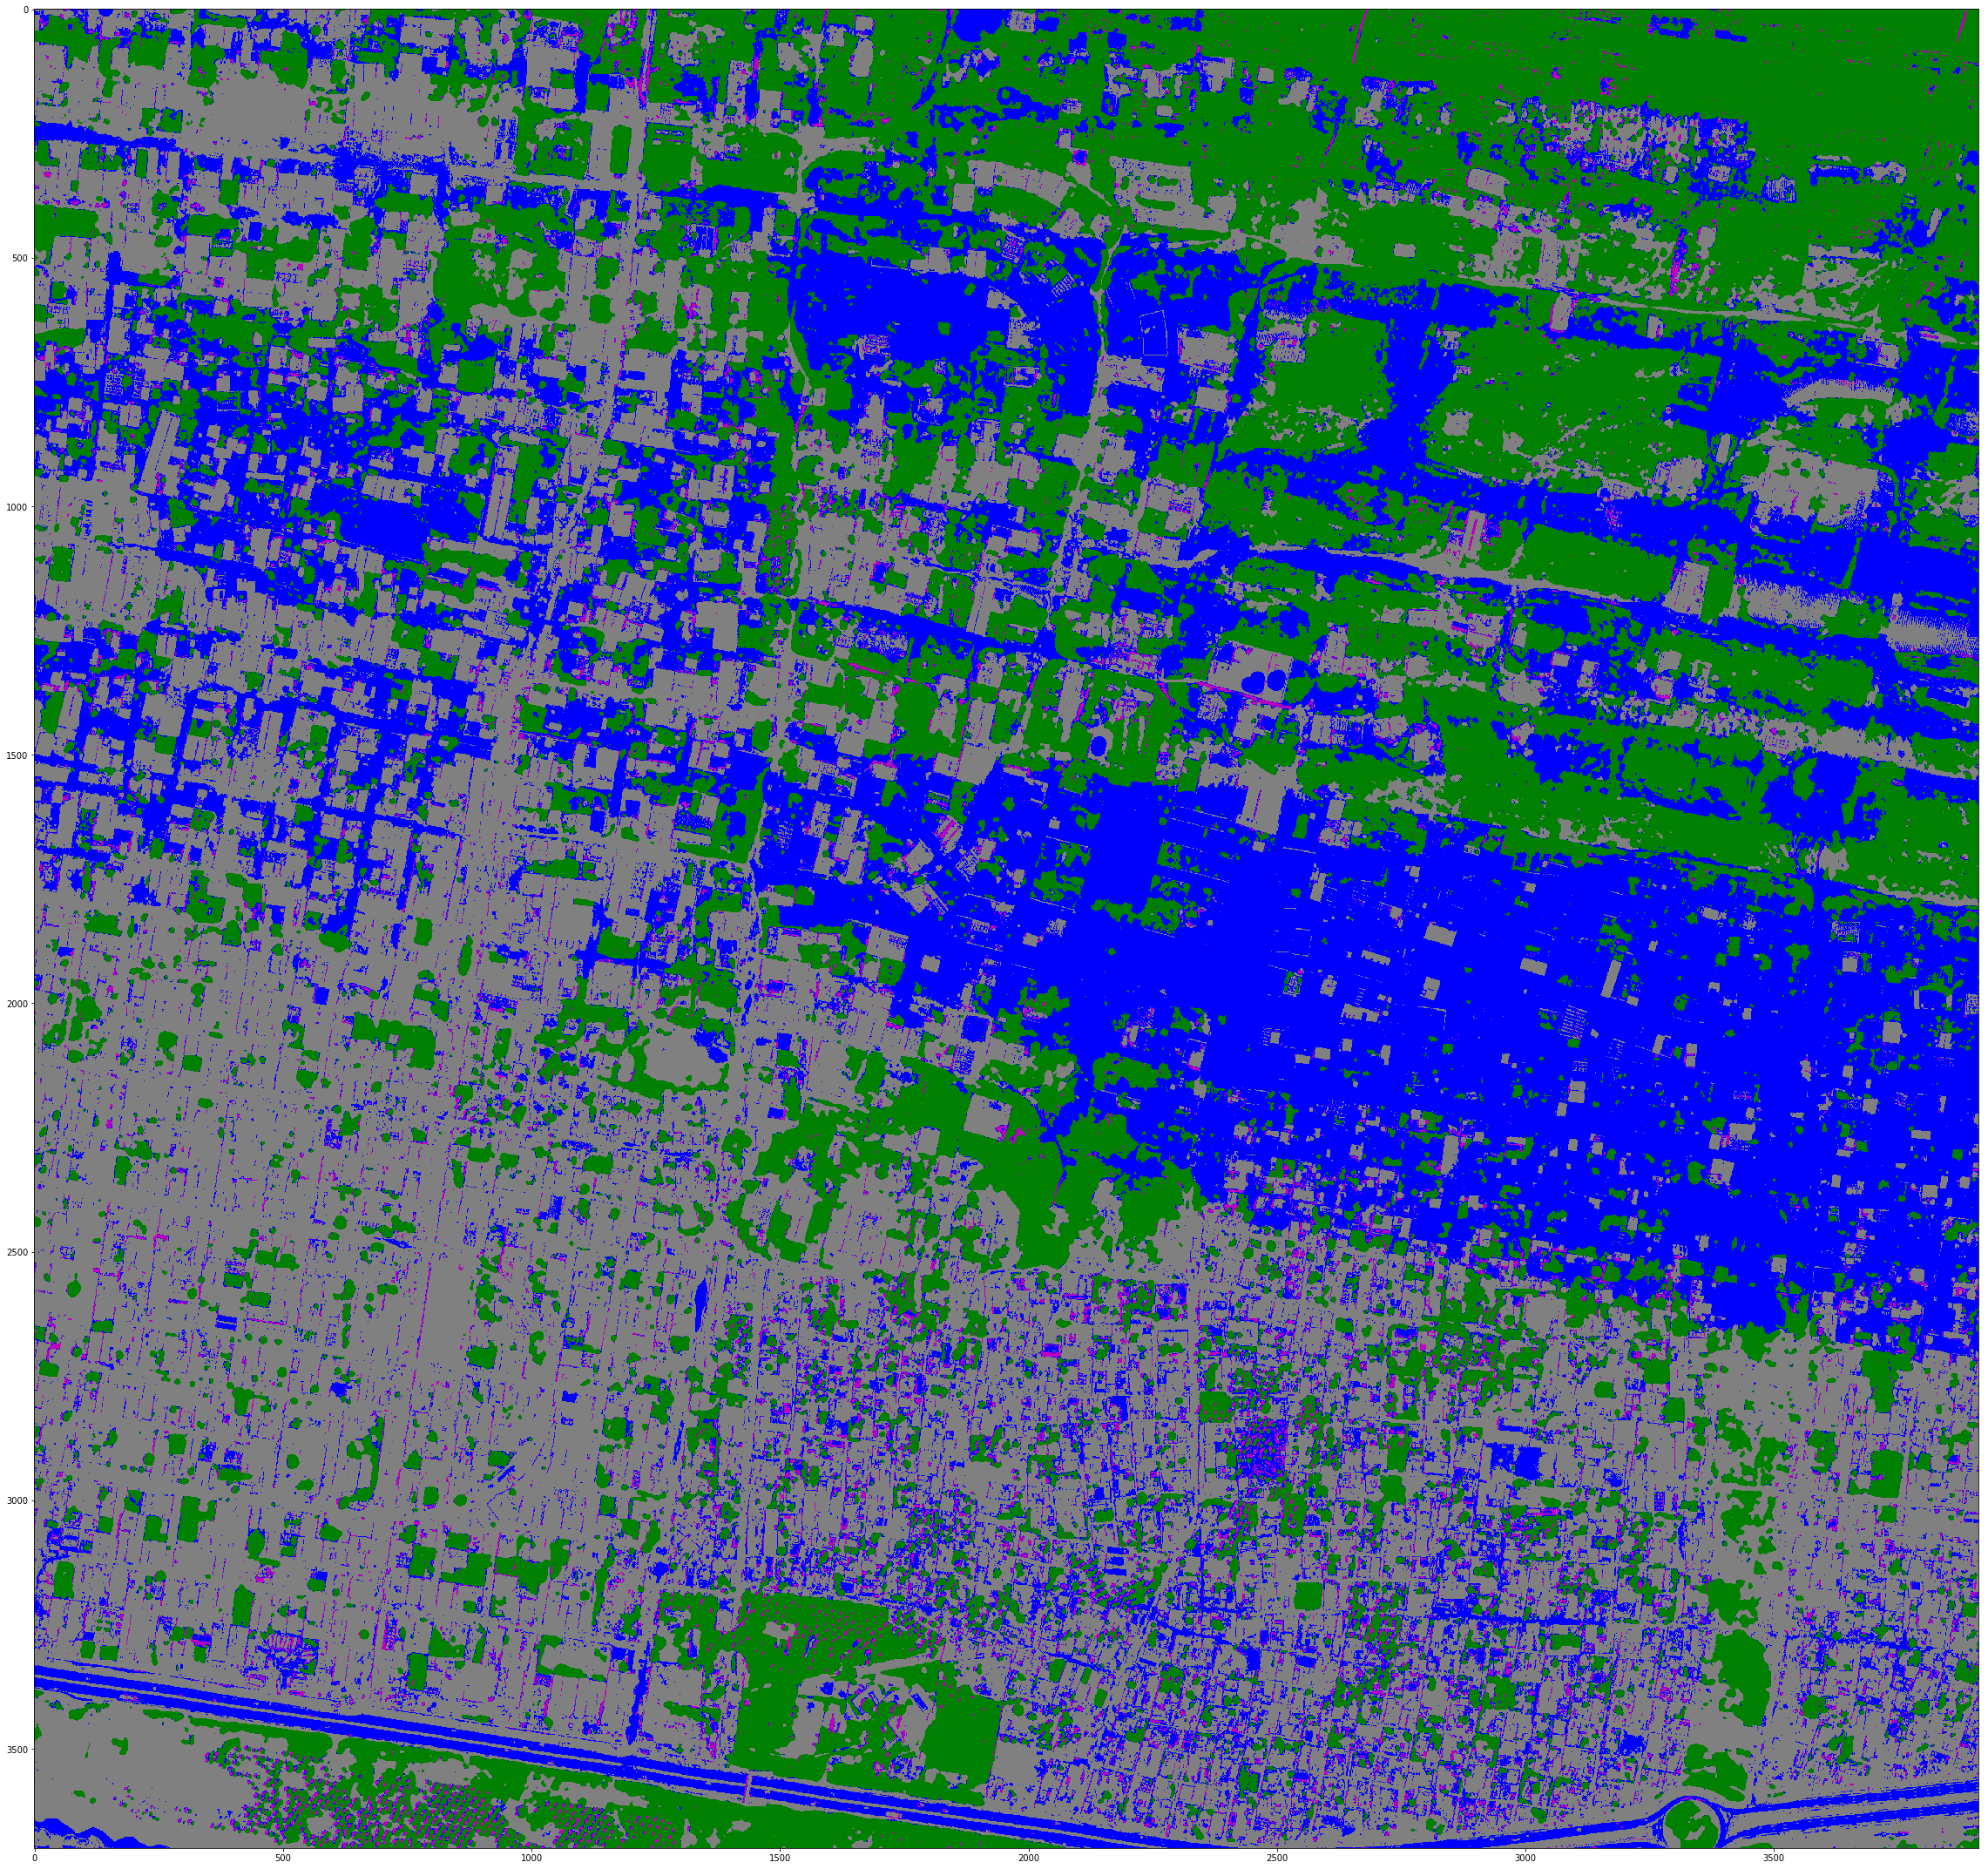

In [62]:
c = [0,1,2,3,4,5,6,7]
southeast_raw_list = [southeast_raw_list[i] for i in c]
# Create stack of inputs for entire image and apply saved linear SVM classifer
southeast_index_stack, se_meta = es.stack(southeast_raw_list)
southeast_index_im = np.rollaxis(southeast_index_stack, 0, 3)
X_southeast_index = southeast_index_im.reshape(-1,8) #Update based on number of model params
predictedClass = loaded_clf.predict(X_southeast_index)

# Plot SVM map
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(southeast_index_im.shape[:2])
cmap = ListedColormap(['m','blue','green','grey'])
ax.imshow(pred_data,cmap=cmap)
plt.show()

In [63]:
# Write out SVM map
with rio.open(combined_svm_outputs_path+'southeast_SVM_map_combined_additional_points_v3.tif', 'w', **southeast_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'),1)

# Random forest

In [64]:
# Define random forest classifier
clf_random_forest = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=10)

In [65]:
# Split training dataset, test size is 40%, training size 60%
Xtrain_rf, Xtest_rf, ytrain_rf, ytest_rf = train_test_split(Xint, yint, test_size=0.4)

In [66]:
# Apply random forest classifier
clf_random_forest.fit(Xtrain_rf, ytrain_rf)
ypred_random_forest = clf_random_forest.predict(Xtest_rf)
accuracy_score(ytest_rf, ypred_random_forest)

0.9198966408268734

In [ ]:
# Save out random forest classfier with accuracy score of 0.9428571428571428
pickle.dump(clf_random_forest, open(combined_svm_outputs_path+'pickle_combined_RF_additional_points_v2', 'wb'))

# Save out random forest classfier with accuracy score of 0.9462809917355371
# pickle.dump(clf_random_forest, open(svm_outputs_path+'pickle_RF_final_with_ndvi', 'wb'))

# Save out random forest classfier with accuracy score of 0.946281
# pickle.dump(clf_random_forest, open(svm_outputs_path+'pickle_RF_final', 'wb'))

# picked 0.9545 accuracy score
# pickled 0.929752 model with better confusion matrix as "best" model confusion matrix did not look good

# pickled 0.9421487603305785 model with better confusion matrix 
# pickle.dump(clf_random_forest, open(svm_outputs_path+'pickle_random_forest_updated', 'wb'))

In [ ]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest_rf, ypred_random_forest))
plt.imshow(confusion_matrix(ytest_rf, ypred_random_forest),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Vegetation', 'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow','True \n Flood','True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

# Validation with 40% of data held back from random forest model development

In [ ]:
# Load saved random forest classifer
loaded_clf_rf = pickle.load(open(combined_svm_outputs_path+'pickle_combined_RF_additional_points_v2', 'rb'))

In [ ]:
# Apply linear kernel random forest classifier to external dataset
ypred_valid_rf = loaded_clf_rf.predict(Xext)
accuracy_score(yext, ypred_valid_rf)

In [ ]:
#Print confusion matrix for random forest
print(confusion_matrix(yext, ypred_valid_rf))

plt.imshow(confusion_matrix(yext, ypred_valid_rf),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow','Predicted \n Flood','Predicted \n Vegetation', 'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow','True \n Flood','True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [ ]:
ypred_df = pd.DataFrame(ypred_valid_rf)
yext_df = pd.DataFrame(yext)
external_xy = pd.concat([yext_df,ypred_df], axis=1, sort=False)
external_xy.columns=['ClassValue','ypred_valid_rf']
external_xy.head()

In [ ]:
flood_only_accuracy = external_xy[external_xy.ClassValue == 2]

# Subset to focus only on flood, all other reference points (shadow, other) removed
# flood_only_accuracy = kmeans_valid_all[kmeans_valid_all.ClassValue == 2]
# print(shadow_only_accuracy.head())

# Calculate accuracy score for flood only subset
ytest_flood_only = flood_only_accuracy['ClassValue']
ypred_flood_only = flood_only_accuracy['ypred_valid_rf']
print(accuracy_score(ytest_flood_only, ypred_flood_only))

conf_matrix = confusion_matrix(ytest_flood_only, ypred_flood_only)

print(conf_matrix)
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=np.arange(3), xticklabels=['Predicted \n Flood', 'Predicted \n Water'],
         yticks=np.arange(3), yticklabels=['True \n Flood', 'True \n Water'])
conf_mat = ax.imshow(conf_matrix, cmap='Blues',
                      interpolation='nearest')
ax.set(title="k-means Confusion Matrix\n")
# divider = make_axes_locatable(ax)
# cax1 = divider.append_axes("right", size="5%", pad=0.15)
# fig.colorbar(conf_mat, cax=cax1)
plt.show()

In [ ]:
# Write out confusion matrix 
confusion_rf_external = confusion_matrix(yext, ypred_valid)
pd.DataFrame(confusion_rf_external).to_csv(combined_svm_outputs_path+'confusion_rf_external_424.csv')

# Plot random forest

In [ ]:
# Create stack of inputs for entire image and apply saved linear SVM classifer
koumassi_index_stack, k_meta = es.stack(koumassi_raw_list)
koumassi_index_im = np.rollaxis(koumassi_index_stack, 0, 3)
X_koumassi_index = koumassi_index_im.reshape(-1,8) #Update based on number of model params
predictedClass = loaded_clf_rf.predict(X_koumassi_index)

# Plot SVM map
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(koumassi_index_im.shape[:2])
cmap = ListedColormap(['m','blue','green','grey'])
ax.imshow(pred_data,cmap=cmap)
plt.show()

In [ ]:
# Write out random forest tif
with rio.open(combined_svm_outputs_path+'koumassi_RF_map_combined_424.tif', 'w', **koumassi_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'),1)

In [ ]:
# Create stack of inputs for entire image and apply saved linear SVM classifer
southeast_index_stack, se_meta = es.stack(southeast_raw_list)
southeast_index_im = np.rollaxis(southeast_index_stack, 0, 3)
X_southeast_index = southeast_index_im.reshape(-1,8) #Update based on number of model params
predictedClass = loaded_clf.predict(X_southeast_index)

# Plot SVM map
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(southeast_index_im.shape[:2])
cmap = ListedColormap(['m','blue','green','grey'])
ax.imshow(pred_data,cmap=cmap)
plt.show()

In [ ]:
with rio.open(combined_svm_outputs_path+'southeast_RF_map_combined_424.tif', 'w', **southeast_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'),1)

# Try clf from southeast

In [ ]:
ypred = southeast_svm_clf.predict(Xext)
accuracy_score(yext, ypred)

In [ ]:
# Create stack of inputs for entire image and apply saved linear SVM classifer
index_stack, meta = es.stack(raw_list)
index_im = np.rollaxis(index_stack, 0, 3)
X_index = index_im.reshape(-1,8) #Update based on number of model params
predictedClass = southeast_svm_clf.predict(X_index)

# Plot SVM map
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(index_im.shape[:2])
cmap = ListedColormap(['m','blue','green','grey'])
ax.imshow(pred_data,cmap=cmap)
plt.show()